In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from depsurf import BCC_OBJ_PATH

assert BCC_OBJ_PATH.exists(), f"Path not found: {BCC_OBJ_PATH}"

In [3]:
from depsurf import parse_structs

parse_structs(BCC_OBJ_PATH / "bindsnoop.bpf.o")

[  bpftool.py:28 ] INFO: /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.min.btf already exists
[decorator.py:17 ] INFO: dump_btf_impl    Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.min.json
[decorator.py:17 ] INFO: normalize_btf    Using /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.min.pkl
[      btf.py:16 ] INFO: Loading BTF from /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.min.pkl


[('struct', 'sock'),
 ('struct', 'sock_common'),
 ('struct', 'in6_addr'),
 ('struct', 'socket'),
 ('struct', 'inet_sock')]

In [4]:
from depsurf import parse_hooks

parse_hooks(BCC_OBJ_PATH / "bindsnoop.bpf.o")

{('func', 'inet6_bind'), ('func', 'inet_bind')}

In [ ]:
result = {}


for obj_file in sorted(BCC_OBJ_PATH.glob("*.bpf.o")):
    hooks = parse_hooks(obj_file)
    structs = parse_structs(obj_file, overwrite=True)
    result[obj_file.name.removesuffix(".bpf.o")] = list(hooks) + structs

result.keys()

In [ ]:
result

In [7]:
from depsurf import BuildVersion

versions = BuildVersion.filter()

versions

[4.4.0-21-generic-amd64,
 4.8.0-22-generic-amd64,
 4.10.0-19-generic-amd64,
 4.13.0-16-generic-amd64,
 4.15.0-20-generic-amd64,
 4.18.0-10-generic-amd64,
 5.0.0-13-generic-amd64,
 5.3.0-18-generic-amd64,
 5.4.0-26-generic-amd64,
 5.8.0-25-generic-amd64,
 5.11.0-16-generic-amd64,
 5.13.0-19-generic-amd64,
 5.15.0-25-generic-amd64,
 5.19.0-21-generic-amd64,
 6.2.0-20-generic-amd64,
 6.5.0-9-generic-amd64,
 6.8.0-22-generic-amd64]

In [8]:
from depsurf import Kind, KernelImages

imgs = KernelImages([v.img for v in versions])

print(imgs.get_changes(Kind.STRUCT, "inet_sock"))
print(imgs.get_changes(Kind.FUNC, "blk_account_io_start"))

print(imgs.get_versions(Kind.STRUCT, "renamedata"))
print(imgs.get_versions(Kind.FUNC, "do_page_cache_ra"))

[      btf.py:16 ] INFO: Loading BTF from /Users/szhong/Downloads/bpf-study/btf/data/btf_norm/4.4.0-21-generic-amd64.pkl
[      btf.py:16 ] INFO: Loading BTF from /Users/szhong/Downloads/bpf-study/btf/data/btf_norm/4.8.0-22-generic-amd64.pkl
[      btf.py:16 ] INFO: Loading BTF from /Users/szhong/Downloads/bpf-study/btf/data/btf_norm/4.10.0-19-generic-amd64.pkl
[      btf.py:16 ] INFO: Loading BTF from /Users/szhong/Downloads/bpf-study/btf/data/btf_norm/4.13.0-16-generic-amd64.pkl
[      btf.py:16 ] INFO: Loading BTF from /Users/szhong/Downloads/bpf-study/btf/data/btf_norm/4.15.0-20-generic-amd64.pkl
[      btf.py:16 ] INFO: Loading BTF from /Users/szhong/Downloads/bpf-study/btf/data/btf_norm/4.18.0-10-generic-amd64.pkl
[      btf.py:16 ] INFO: Loading BTF from /Users/szhong/Downloads/bpf-study/btf/data/btf_norm/5.0.0-13-generic-amd64.pkl
[      btf.py:16 ] INFO: Loading BTF from /Users/szhong/Downloads/bpf-study/btf/data/btf_norm/5.3.0-18-generic-amd64.pkl
[      btf.py:16 ] INFO: Loa

[('4.10', '4.13', ["(<StructCause.FIELD_ADD: 'Field added'>, [('defer_connect', {'kind': 'TYPEDEF', 'name': '__u8'})])"]), ('5.8', '5.11', ["(<StructCause.FIELD_ADD: 'Field added'>, [('recverr_rfc4884', {'kind': 'TYPEDEF', 'name': '__u8'})])"]), ('5.13', '5.15', ["(<StructCause.FIELD_REMOVE: 'Field removed'>, [('rx_dst_ifindex', {'kind': 'INT', 'name': 'int'})])"]), ('6.2', '6.5', ["(<StructCause.FIELD_ADD: 'Field added'>, [('local_port_range', {'kind': 'STRUCT', 'name': '(anon)'})])", "(<StructCause.FIELD_TYPE: 'Field type changed'>, [('inet_id', {'kind': 'TYPEDEF', 'name': '__u16'}, {'kind': 'TYPEDEF', 'name': 'atomic_t'})])"]), ('6.5', '6.8', ["(<StructCause.FIELD_ADD: 'Field added'>, [('inet_flags', {'kind': 'INT', 'name': 'long unsigned int'})])", "(<StructCause.FIELD_REMOVE: 'Field removed'>, [('cmsg_flags', {'kind': 'TYPEDEF', 'name': '__u16'}), ('recverr', {'kind': 'TYPEDEF', 'name': '__u8'}), ('is_icsk', {'kind': 'TYPEDEF', 'name': '__u8'}), ('freebind', {'kind': 'TYPEDEF', 'n

In [ ]:
from depsurf import reload_depsurf
from depsurf.plot import setup_pandas

import pandas as pd

reload_depsurf()

from depsurf import Scorer, Causes, FileLogger, KernelImages, OUTPUT_PATH, get_diff_fn, Kind

# imgs = KernelImages([v.img for v in versions])

from collections import defaultdict

total_causes = Causes()

counts = {}
cause_state = defaultdict(dict)
cause_delta = defaultdict(dict)
for prog_name, deps in result.items():
    # with FileLogger(OUTPUT_PATH / "bcc" / f"{name}.txt"):
    # print(f"{' ' + name + ' ':=^80}")
    # scorer = Scorer(imgs)
    # causes = scorer.analyze(hooks, structs, nindent=0)
    # causes.print(nindent=0)

    # count the first element in the list of tuples

    for v in versions:
        for construct, dep_name in deps:
            if construct == "struct":
                cause_state[(prog_name, construct, dep_name)][v] = (
                    v.img.btf.get_struct(dep_name) is not None
                )
            elif construct == "func":
                cause_state[(prog_name, construct, dep_name)][v] = (
                    v.img.btf.get_func(dep_name) is not None
                )
            elif construct == "tracepoint":
                cause_state[(prog_name, construct, dep_name)][v] = (
                    v.img.tracepoints.events.get(dep_name) is not None
                )

    for v1, v2 in zip(versions, versions[1:]):
        for construct, dep_name in deps:
            if construct == "struct":
                t1 = v1.img.btf.get_struct(dep_name)
                t2 = v2.img.btf.get_struct(dep_name)
                if t1 is None or t2 is None:
                    continue
                changes =  get_diff_fn(Kind.STRUCT)(t1, t2)
                cause_delta[(prog_name, construct, dep_name)][(v1, v2)] = bool(changes)
            elif construct == "func":
                t1 = v1.img.btf.get_func(dep_name)
                t2 = v2.img.btf.get_func(dep_name)
                if t1 is None or t2 is None:
                    continue
                changes =  get_diff_fn(Kind.FUNC)(t1, t2)
                cause_delta[(prog_name, construct, dep_name)][(v1, v2)] = bool(changes)
            elif construct == "tracepoint":
                t1 = v1.img.tracepoints.events.get(dep_name)
                t2 = v2.img.tracepoints.events.get(dep_name)
                if t1 is None or t2 is None:
                    continue
                changes =  bool(get_diff_fn(Kind.STRUCT)(t1, t2))

                t1 = v1.img.tracepoints.funcs.get(dep_name)
                t2 = v2.img.tracepoints.funcs.get(dep_name)
                if t1 is None or t2 is None:
                    continue
                changes |= bool( get_diff_fn(Kind.FUNC)(t1, t2))

                cause_delta[(prog_name, construct, dep_name)][(v1, v2)] = bool(changes)


    df = pd.DataFrame(deps)
    count = df.groupby(0).count().T
    counts[prog_name] = count
# total_causes.print()

# pd.DataFrame(cause_state, index=["1"]).Tcause_state

import numpy as np

df_delta = pd.DataFrame(cause_delta).T
df_delta = df_delta.replace({True: "❌", False: "-", np.nan: ""})
df_delta.columns = [f"{v1.short_version} {v2.short_version}" for v1, v2 in df_delta.columns]
df_delta = df_delta[(df_delta != "-").any(axis=1)]
df_delta

In [ ]:
df_state = pd.DataFrame(cause_state).T
df_state.columns = [v.short_version for v in df_state.columns]
df_state = df_state.replace({True: "✅", False: "❌"})
df_state

In [ ]:
df_counts = pd.concat(counts, axis=0).fillna(0).astype(int)
df_counts.index = df_counts.index.droplevel(-1)
df_counts

<Axes: >

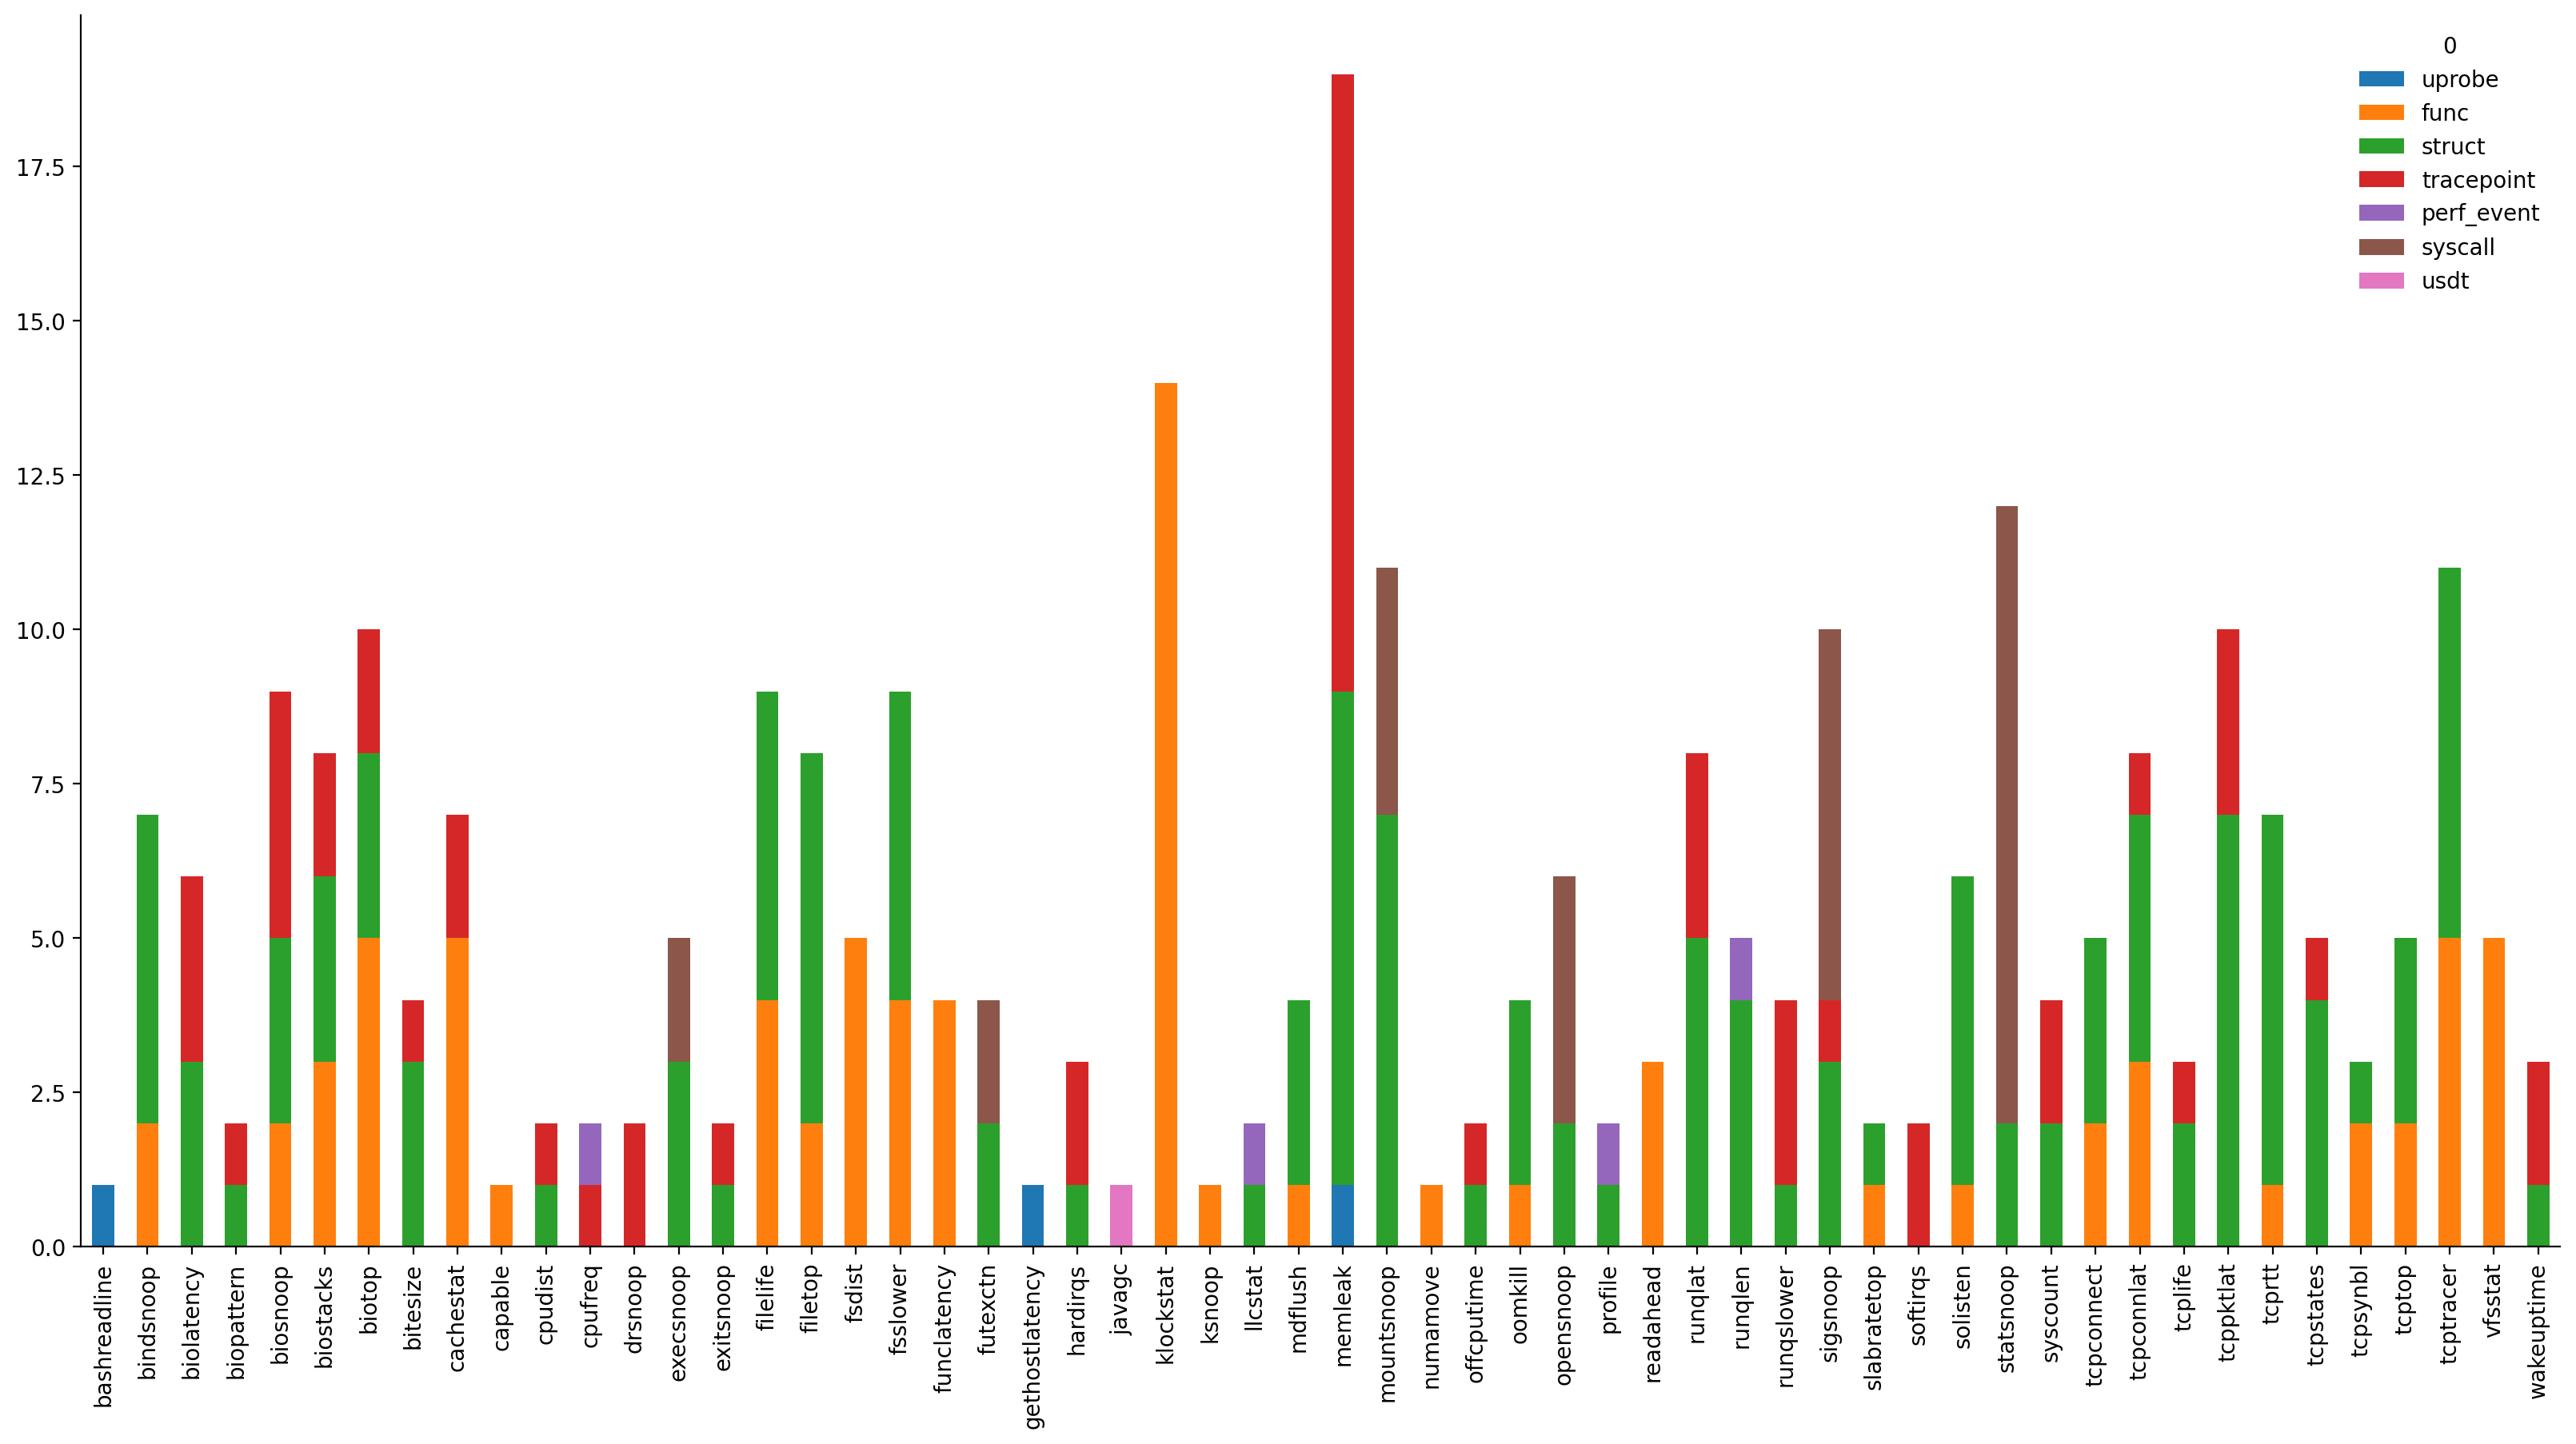

In [10]:
# plot df_counts

import matplotlib.pyplot as plt

df_counts.plot(kind="bar", stacked=True, figsize=(20, 10))

In [11]:
import pandas as pd

from depsurf import category_map

df = pd.DataFrame(scores)
df = df.sort_values("score", ascending=False)
df["category"] = df.name.map(lambda x: category_map[x].value)
df = df[df.score > 0]
df

NameError: name 'scores' is not defined

Text(0.5, 1.0, 'Unstable Score of BPF Programs (lower is better)')

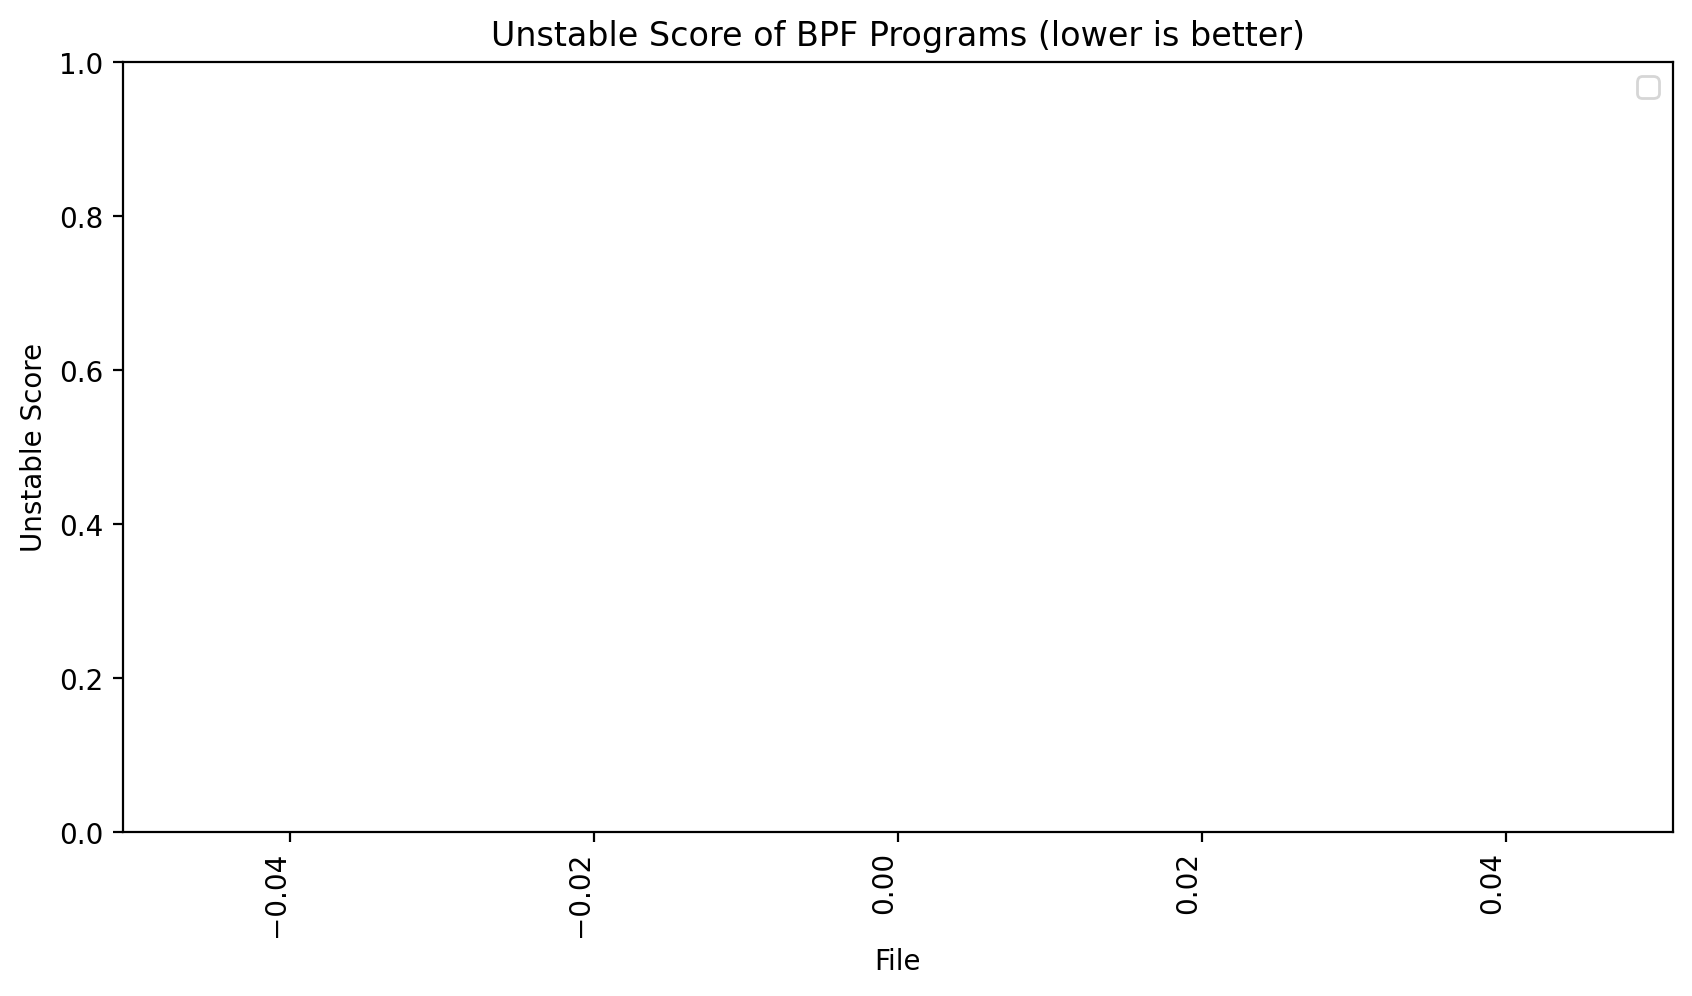

In [ ]:
import matplotlib.pyplot as plt
from depsurf import Category

fig, ax = plt.subplots(figsize=(10, 5), dpi=200)

# remove margin for the bar plot
plt.margins(x=0.01)

curr_x = 0
for category, cat_df in df.groupby("category"):
    color = Category(category).color
    ax.bar(cat_df.name, cat_df["score"], color=color, label=category)
    xlen = len(cat_df) / len(df)
    ax.axhline(
        cat_df["score"].mean(),
        linestyle="--",
        xmin=curr_x,
        xmax=curr_x + xlen,
        color="black",
        linewidth=1,
    )
    curr_x += xlen


handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

for label in ax.get_xticklabels():
    label.set_rotation(90)
    label.set_horizontalalignment("right")

ax.set_ylabel("Unstable Score")
ax.set_xlabel("File")
ax.set_title("Unstable Score of BPF Programs (lower is better)")